# Fitting a drift diffusion model to SET data

## Todos & thoughs
* could include within-subjects effects using patsy package -> http://ski.clps.brown.edu/hddm_docs/tutorial_python.html#within-subject-effects
* integrate pupil pattern (lin, quad, lin-quad) as predictor in regression -> http://ski.clps.brown.edu/hddm_docs/tutorial_python.html#fitting-regression-models

## Issues
* ValueError: Buffer dtype mismatch, expected 'double' but got 'long' -> rts must be coded in seconds (not miliseconds)
* KeyError: 'rt' -> column names must match up with example here: http://ski.clps.brown.edu/hddm_docs/tutorial_python.html
* ZeroProbability: Stochastic wfpt(0span).8.0's value is outside its support, or it forbids its parents' current values. -> remove all subjects for which it throws this error
* Could not generate output statistics for a_subj(1span).12.0 -> number of samples must greater than number of burn. e.g., model.sample(300, burn=300) does NOT work, but model.sample(500, burn=300) works!

## HDDM parameters (http://ski.clps.brown.edu/hddm_docs/methods.html)
* sv, st, sz -> noise parameters capturing inter-trial variability in the drift-rate, the non-decision time and the starting point: when errors are faster or slower than correct responses.
* v -> The speed with which the accumulation process approaches one of the two boundaries is called drift-rate v and represents the relative evidence for or against a particular response.
* a -> The distance between the two boundaries (i.e. threshold a) influences how much evidence must be accumulated until a response is executed. 
* t -> Response time, however, is not solely comprised of the decision making process – perception, movement initiation and execution all take time and are lumped in the DDM by a single non-decision time parameter t.
* z -> The model also allows for a prepotent bias z affecting the starting point of the drift process relative to the two boundaries.

## Code

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import hddm
# import os
import glob
import numpy as np
from first import first

In [58]:
file_dir = "C:/Users/maria/MEGAsync/Berkeley/R scripts/sequentialset/subj_files/databoth/raw_data"
n_subj = 61  # there are 61 in total
preprocess_data = False
run_acc_model = True
run_stim_model = True
n_burn = 1000  # traces look good after about 1000
n_sample = 5000 + n_burn  # n_samples must be > n_burn

In [16]:
# Read in and clean data
if preprocess_data:
    files = glob.glob(file_dir + "/seq*SET*.csv")[:n_subj]
    all_data = pd.DataFrame()

    for file in files:

        # Drop unncessary rows and columns
        data_file = pd.read_csv(file, low_memory=False)
        data_file = data_file[data_file.TrainorExp == "Train"]
        data_file = data_file[["Subject", "TrialId", "CRESP", "RESP", "ACC", "RT", "Category", "SETornoSET"]]

        # Add all subjects into one file
        all_data = all_data.append(data_file)

    # Remove eye tracking data
    grouped = all_data.groupby(["Subject", "TrialId"], as_index=False)
    all_data = grouped.agg(first)

    all_data['RT'] = all_data['RT'] / 1000
    all_data = all_data.rename(columns={"Subject": "subj_idx", "RT": "rt"})

    all_data.to_csv("hddm_all_data.csv")
    
else:
    all_data = pd.read_csv("hddm_all_data.csv")
    
exclude = [8, 19, 33, 303, 309, 320]
all_data = all_data[np.logical_not(all_data.subj_idx.isin(exclude))]
all_data.describe()

,Unnamed: 0,subj_idx,TrialId,ACC,rt
count,4363.000000,4363.000000,4363.000000,3908.0,4363.000000
mean,2423.823745,140.821682,42.309191,1.0,0.616208
std,1412.876949,145.093283,23.957359,0.0,0.623440
min,0.000000,3.000000,2.000000,1.0,0.002000
25%,1250.500000,20.000000,21.000000,1.0,0.312000
50%,2421.000000,35.000000,41.000000,1.0,0.442000
75%,3671.500000,314.000000,63.000000,1.0,0.668000
max,4842.000000,330.000000,83.000000,1.0,8.020000


## Accuracy model

In [37]:
# Reshape data for ACCURACY MODEL
acc_data = all_data.copy()
acc_data = acc_data.rename(columns={"ACC": "response"})
acc_data.to_csv("acc_data.csv")
acc_data.head()

,Unnamed: 0,subj_idx,TrialId,CRESP,RESP,response,rt,Category,SETornoSET
0,0,3.0,2.0,q,q,1.0,0.427,1span,noSET
1,1,3.0,3.0,q,q,1.0,1.466,3span,noSET
2,2,3.0,4.0,q,q,1.0,0.524,1span,noSET
3,3,3.0,5.0,q,q,1.0,1.470,2span,noSET
4,4,3.0,6.0,p,p,1.0,0.597,2span,SET


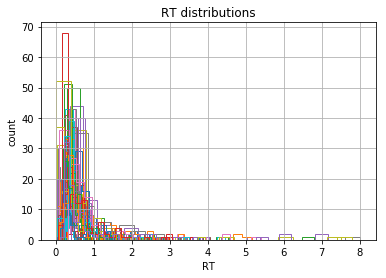

In [59]:
# Plot RT distributions
acc_data = hddm.utils.flip_errors(acc_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in acc_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [ ]:
# Create accuracy model
if run_acc_model:
    acc_model = hddm.HDDM(acc_data,
                          depends_on={'a': 'Category', 'v': 'Category'},
                          p_outlier=0.05)
    acc_model.find_starting_values()
    acc_model.sample(n_sample, burn=n_burn)
    acc_traces = acc_model.get_traces()
    acc_traces.to_csv("acc_traces.csv")

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [------           16%                  ] 1013 of 6000 complete in 323.7 sec

In [ ]:
acc_model.plot_posteriors(['a', 't', 'v', 'a_std'])

In [ ]:
stats = acc_model.gen_stats()
# stats

In [ ]:
a0, a1, a2, a3 = acc_model.nodes_db.node[['a(0span)', 'a(1span)', 'a(2span)', 'a(3span)']]
hddm.analyze.plot_posterior_nodes([a0, a1, a2, a3])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

In [ ]:
v0, v1, v2, v3 = acc_model.nodes_db.node[['v(0span)', 'v(1span)', 'v(2span)', 'v(3span)']]
hddm.analyze.plot_posterior_nodes([v0, v1, v2, v3])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

In [ ]:
acc_model.plot_posterior_predictive(figsize=(14, 10))

In [ ]:
models = []
for i in range(5):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(5000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

## Stimulus model

In [7]:
# Read in data and bring in correct shape for STIMULUS CODING MODEL
# In that case, the ‘resp’ column in your data should contain 0 and 1 for the chosen stimulus (or direction),
# not whether the response was correct or not as you would use in accuracy coding.
# You then have to provide another column (referred to as stim_col) which contains information about which the correct response was.
stim_data = all_data.copy()
stim_data = stim_data.rename(columns={"RESP": "response", "CRESP": "correct_response"})
stim_data = stim_data.replace({'response': {'p': 1, 'q': 0}})
stim_data = stim_data.replace({'correct_response': {'p': 1, 'q': 0}})
stim_data.to_csv('stim_data.csv')
stim_data.head()

,Unnamed: 0,subj_idx,TrialId,correct_response,response,ACC,rt,Category,SETornoSET
0,0,3.0,2.0,0,0,1.0,0.427,1span,noSET
1,1,3.0,3.0,0,0,1.0,1.466,3span,noSET
2,2,3.0,4.0,0,0,1.0,0.524,1span,noSET
3,3,3.0,5.0,0,0,1.0,1.470,2span,noSET
4,4,3.0,6.0,1,1,1.0,0.597,2span,SET


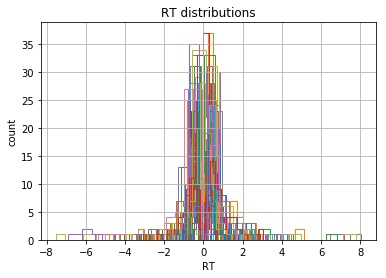

In [8]:
# Plot RT distributions
stim_data = hddm.utils.flip_errors(stim_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in stim_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [9]:
if run_stim_model:
    # Run hddm on SET vs noSET responses
    stim_model = hddm.HDDMStimCoding(stim_data,
                                     split_param='v',
                                     stim_col='correct_response',
                                     depends_on={'a': 'Category', 'v': 'Category'},
                                     p_outlier=0.05)
    stim_model.find_starting_values()
    stim_model.sample(1000, burn=1000)
    stim_model.save('stim_model_0outliers_10000samples_avdeponCategory')
else:
    stim_model = hddm.load('stim_model')

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1000 of 1000 complete in 285.9 secCould not generate output statistics for a_subj(1span).18.0
Could not generate output statistics for t_subj.324.0
Could not generate output statistics for a_subj(1span).28.0
Could not generate output statistics for a_subj(1span).37.0
Could not generate output statistics for a_subj(0span).317.0
Could not generate output statistics for t_subj.316.0
Could not generate output statistics for a_subj(0span).327.0
Could not generate output statistics for a_subj(0span).316.0
Could not generate output statistics for a_subj(1span).10.0
Could not generate output statistics for a_subj(1span).15.0
Could not generate output statistics for a_subj(0span).318.0
Could not generate output statistics for a_subj(1span).17.0
Could not generate output statistics for a_subj(1span).4.0
Could not generate output statistics for a_subj(0span).328.0
Could not generate output statistics for t_subj.323.0
Could not generate output statistics f

TypeError: 'NoneType' object is not subscriptable

In [ ]:
a0, a1, a2, a3 = stim_model.nodes_db.node[['a(0span)', 'a(1span)', 'a(2span)', 'a(3span)']]
hddm.analyze.plot_posterior_nodes([a0, a1, a2, a3])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

In [ ]:
v0, v1, v2, v3 = stim_model.nodes_db.node[['v(0span)', 'v(1span)', 'v(2span)', 'v(3span)']]
hddm.analyze.plot_posterior_nodes([v0, v1, v2, v3])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')